# Data exploration

In [ ]:
import os
import pandas as pd
import numpy as np

data_folder = '../../data/gr64f_dmVS_14-09-2023/'
minimal_trials = 180
os.listdir(data_folder)

['trial_lengths.csv',
 'trial_ends.csv',
 'trial_starts.csv',
 'trial_counts.csv',
 'experiments',
 'choices.csv',
 'quality_control.csv',
 'metadata.csv',
 'rewards.csv']

In [17]:
choices = np.loadtxt(data_folder + 'choices.csv', delimiter=',')
rewards = np.loadtxt(data_folder + 'rewards.csv', delimiter=',')
# remove the nan values to make a staggered array
cleaned_choices = []
cleaned_rewards = []
for i in range(len(choices)):
    c = choices[i][~np.isnan(choices[i])]
    r = rewards[i][~np.isnan(rewards[i])]
    if len(c) < minimal_trials:
        continue
    cleaned_choices.append(c)
    cleaned_rewards.append(r)
cleaned_choices = np.array(cleaned_choices, dtype=object)
cleaned_rewards = np.array(cleaned_rewards, dtype=object)


In [ ]:
import os
import pandas as pd
import numpy as np

def fetch_behavioral_data(data_folder, minimum_trials):
    # List files in the data folder
    files = os.listdir(data_folder)

    # verify that the data folder contains the required files
    if 'choices.csv' not in files or 'rewards.csv' not in files and 'metadata.csv' not in files:
        raise FileNotFoundError('The data folder is missing important files')
    
    # Load choices and rewards data
    choices = np.loadtxt(data_folder + 'choices.csv', delimiter=',')
    rewards = np.loadtxt(data_folder + 'rewards.csv', delimiter=',')
    
    # Remove the nan values to make a staggered array
    cleaned_choices = []
    cleaned_rewards = []
    for i in range(len(choices)):
        c = choices[i][~np.isnan(choices[i])]
        r = rewards[i][~np.isnan(rewards[i])]
        if len(c) < minimum_trials:
            continue
        cleaned_choices.append(c)
        cleaned_rewards.append(r)
    
    cleaned_choices = np.array(cleaned_choices, dtype=object)
    cleaned_rewards = np.array(cleaned_rewards, dtype=object)
    
    # load metadata
    metadata = pd.read_csv(data_folder + 'metadata.csv')

    return cleaned_choices, cleaned_rewards, metadata

# Example usage
data_folder = '../../data/gr64f_dmVS_14-09-2023/'
minimum_trials = 150
cleaned_choices, cleaned_rewards = fetch_choices_and_rewards(data_folder, minimum_trials)

In [19]:
len(cleaned_choices), len(cleaned_rewards)

(425, 425)

In [ ]:
data_folder = '../../data/gr64f_dmVS_14-09-2023_detailed/'

In [21]:
encounter_data = [pd.read_csv(os.path.join(data_folder,f)) for f in list(filter(lambda x: 'encounter' in x, os.listdir(data_folder)))]

In [22]:
import matplotlib.pyplot as plt
enc = encounter_data[1]

In [23]:
enc = enc[enc['Current Odor'] != 0.0]

In [24]:
enc

,Encounter Number,Current Trial,Current Odor,Encounter Decision,Encounter Duration,Encounter Reward,Encounter Start Time
1,1,0,1.0,0,3.935481,0,08-30-2023 09:53:13:167495
3,3,0,2.0,1,2.281900,0,08-30-2023 09:53:22:691032
5,5,1,1.0,1,2.261952,0,08-30-2023 09:53:34:402645
7,7,2,2.0,1,1.408236,0,08-30-2023 09:53:38:964449
9,9,3,1.0,1,2.074453,0,08-30-2023 09:53:45:021096
...,...,...,...,...,...,...,...
1086,1086,488,2.0,1,2.426857,0,08-30-2023 12:22:30:190226
1088,1088,489,1.0,0,5.323764,0,08-30-2023 12:22:39:787096
1090,1090,489,1.0,0,5.031728,0,08-30-2023 12:22:51:781738
1092,1092,489,2.0,0,0.232380,0,08-30-2023 12:23:00:379966


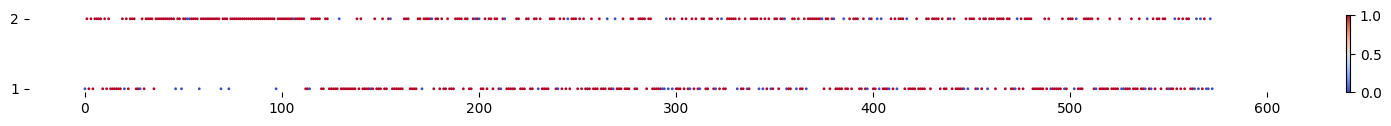

In [25]:
plt.figure(figsize=(20,1))
plt.scatter(np.arange(len(enc['Current Odor'])), enc['Current Odor'], c=enc['Encounter Decision'], cmap='coolwarm', s=1)
plt.box(False)
plt.colorbar()
plt.show()

In [26]:
enc_odors = enc['Current Odor'].values
# get transition matrix
vals = np.unique(enc_odors)
transitions = np.zeros((len(vals), len(vals)))
for i in range(1, len(enc_odors)):
    transitions[np.where(vals == enc_odors[i-1])[0][0], np.where(vals == enc_odors[i])[0][0]] += 1
transition_probs = transitions / transitions.sum(axis=1)[:, None]
transition_probs

# create a function to calculate the transition matrix as a running average
def calculate_transition_matrix(sequence, states):
    transitions = np.zeros((len(states), len(states)))
    for i in range(1, len(sequence)):
        transitions[np.where(states == sequence[i-1])[0][0], np.where(states == sequence[i])[0][0]] += 1
    transition_probs = transitions / transitions.sum(axis=1)[:, None]
    return transition_probs

def running_transition_matrix(current_odors, states, window_size):
    transition_matrices = []
    for i in range(len(current_odors) - window_size):
        sequence = current_odors[i:i+window_size]
        transition_matrix = calculate_transition_matrix(sequence, states)
        transition_matrices.append(transition_matrix)
    return np.array(transition_matrices)

# Example usage
window_size = 100
transition_matrices = running_transition_matrix(enc_odors, vals, window_size)


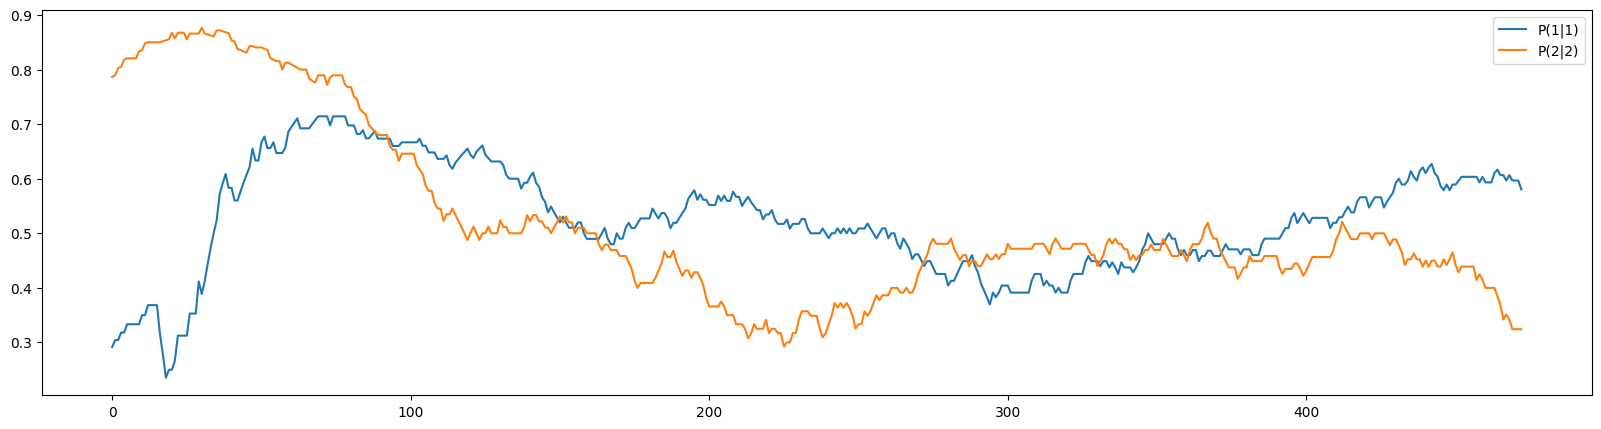

In [27]:
plt.figure(figsize=(20,5))
plt.plot(transition_matrices[:,0,0], label='P(1|1)')
# plt.plot(transition_matrices[:,0,1], label='P(2|1)')
# plt.plot(transition_matrices[:,1,0], label='P(1|2)')
plt.plot(transition_matrices[:,1,1], label='P(2|2)')
plt.legend()
